In [1]:
# to disable GPU
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:

import os
os.chdir('T:/Dropbox/Projects/LSTM-forecast/src')
import featureEng as fe
import processStocks as ps
import lstm
import getStocks
import visualize
import predicts
import pandas as pd

C:\Users\hende\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [4]:
# view tenslow enabled devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14194642139870983461
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6723171778
locality {
  bus_id: 1
}
incarnation: 2392220203161837372
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


# User parameters

In [5]:
####TODO: reshaping so we can plot various n_in, n_out
# model seems to work, but cant redim for plot
ticker = 'unh'
n_in = 5
n_out = 1
target = 'd1close'
rngSpt = 20 # number of random stocks to select as the supporting data features

In [6]:
import imp
imp.reload(getStocks)

<module 'getStocks' from 'T:\\Dropbox\\Projects\\LSTM-forecast\\src\\getStocks.py'>

In [7]:
# collect a bunch of data from the market, save it to directory
# getStocks.get_mkt_data(source='yahoo')

# Load Data
### Several methods available here:
* Load a single stock
* get a refresh of the stock
* load a single stock as the target while using many other stocks as additional features

In [8]:
# load dataset
# dataset = getStocks.get_single(ticker=ticker, save=True)
# dataset = getStocks.load_single(ticker)
dataset = getStocks.join_tgt_spt(target_ticker='UNH', number_spt=rngSpt)
dataset.reset_index(level=0, inplace=True)
dataset.rename(columns={'Adj Close':'AdjCls'}, inplace=True)

In [9]:
dataset.head()

,Date,Open,High,Low,Close,AdjCls,Volume,ABCOpen,ABCHigh,ABCLow,ABCClose,ABCAdj Close,ABCVolume,CMAOpen,CMAHigh,CMALow,CMAClose,CMAAdj Close,CMAVolume,CAHOpen,CAHHigh,CAHLow,CAHClose,CAHAdj Close,CAHVolume,FBOpen,FBHigh,FBLow,FBClose,FBAdj Close,FBVolume,FBHSOpen,FBHSHigh,FBHSLow,FBHSClose,FBHSAdj Close,FBHSVolume,IFFOpen,IFFHigh,IFFLow,IFFClose,IFFAdj Close,IFFVolume,UNMOpen,UNMHigh,UNMLow,UNMClose,UNMAdj Close,UNMVolume,NDAQOpen,NDAQHigh,NDAQLow,NDAQClose,NDAQAdj Close,NDAQVolume,BIIBOpen,BIIBHigh,BIIBLow,BIIBClose,BIIBAdj Close,BIIBVolume,REGNOpen,REGNHigh,REGNLow,REGNClose,REGNAdj Close,REGNVolume,GGPOpen,GGPHigh,GGPLow,GGPClose,GGPAdj Close,GGPVolume,NUEOpen,NUEHigh,NUELow,NUEClose,NUEAdj Close,NUEVolume,KSUOpen,KSUHigh,KSULow,KSUClose,KSUAdj Close,KSUVolume,LOWOpen,LOWHigh,LOWLow,LOWClose,LOWAdj Close,LOWVolume,DLROpen,DLRHigh,DLRLow,DLRClose,DLRAdj Close,DLRVolume,MCHPOpen,MCHPHigh,MCHPLow,MCHPClose,MCHPAdj Close,MCHPVolume,FOpen,FHigh,FLow,FClose,FAdj Close,FVolume,BAOpen,BAHigh,BALow,BAClose,BAAdj Close,BAVolume,SHWOpen,SHWHigh,SHWLow,SHWClose,SHWAdj Close,SHWVolume,SCHWOpen,SCHWHigh,SCHWLow,SCHWClose,SCHWAdj Close,SCHWVolume
0,1984-10-17,0.144531,0.148438,0.144531,0.144531,0.126899,9868800,NaN,NaN,NaN,NaN,NaN,NaN,4.907407,4.944445,4.907407,4.944445,1.813011,99900,1.604800,1.604800,1.579725,1.604800,0.888511,63900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.458333,8.750000,8.416667,8.708333,3.661374,181200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.250000,1.281250,1.250000,1.270833,0.674222,283200,6.916667,6.958333,6.875000,6.937500,2.771326,181200,0.675781,0.687500,0.671875,0.679688,0.454419,5046400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.858795,2.934827,2.843588,2.904414,0.876193,13468800,8.277778,8.370370,8.222222,8.259259,4.116731,1637400,3.609375,3.609375,3.500000,3.578125,1.991714,333600,NaN,NaN,NaN,NaN,NaN,NaN
1,1984-10-18,0.148438,0.156250,0.148438,0.148438,0.130329,5324800,NaN,NaN,NaN,NaN,NaN,NaN,4.944445,5.055555,4.907407,5.055555,1.853752,87600,1.604800,1.604800,1.504500,1.529575,0.846862,132600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.666667,9.000000,8.625000,8.958333,3.766486,322800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.270833,1.270833,1.250000,1.260417,0.668695,134400,6.937500,6.979167,6.916667,6.979167,2.787970,21000,0.683594,0.726563,0.683594,0.726563,0.485758,3139200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.904414,3.071684,2.904414,3.071684,0.926655,30431100,8.277778,8.629630,8.277778,8.574074,4.273647,3057600,3.578125,3.687500,3.562500,3.687500,2.052596,188800,NaN,NaN,NaN,NaN,NaN,NaN
2,1984-10-19,0.148438,0.148438,0.144531,0.144531,0.126899,3043200,NaN,NaN,NaN,NaN,NaN,NaN,5.055555,5.166667,5.037037,5.129630,1.880913,831900,1.529575,1.529575,1.404200,1.429275,0.791330,65300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,9.291667,9.000000,9.125000,3.836560,664500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.276042,1.296875,1.260417,1.260417,0.668695,908800,7.000000,7.125000,7.000000,7.041667,2.812938,272400,0.738281,0.765625,0.738281,0.738281,0.493593,10806400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.117303,3.124906,3.026065,3.041271,0.917480,30760000,8.574074,8.777778,8.444445,8.574074,4.273647,5769800,3.765625,3.859375,3.765625,3.781250,2.104781,516000,NaN,NaN,NaN,NaN,NaN,NaN
3,1984-10-22,0.144531,0.148438,0.144531,0.144531,0.126899,2326400,NaN,NaN,NaN,NaN,NaN,NaN,5.129630,5.148148,5.074074,5.074074,1.860542,410400,1.429275,1.479425,1.354050,1.391662,0.770506,396000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.125000,9.458333,9.125000,9.333333,3.924153,360000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.250000,1.286458,1.239583,1.265

In [10]:
for col in dataset.columns:
    print(col)

Date
Open
High
Low
Close
AdjCls
Volume
ABCOpen
ABCHigh
ABCLow
ABCClose
ABCAdj Close
ABCVolume
CMAOpen
CMAHigh
CMALow
CMAClose
CMAAdj Close
CMAVolume
CAHOpen
CAHHigh
CAHLow
CAHClose
CAHAdj Close
CAHVolume
FBOpen
FBHigh
FBLow
FBClose
FBAdj Close
FBVolume
FBHSOpen
FBHSHigh
FBHSLow
FBHSClose
FBHSAdj Close
FBHSVolume
IFFOpen
IFFHigh
IFFLow
IFFClose
IFFAdj Close
IFFVolume
UNMOpen
UNMHigh
UNMLow
UNMClose
UNMAdj Close
UNMVolume
NDAQOpen
NDAQHigh
NDAQLow
NDAQClose
NDAQAdj Close
NDAQVolume
BIIBOpen
BIIBHigh
BIIBLow
BIIBClose
BIIBAdj Close
BIIBVolume
REGNOpen
REGNHigh
REGNLow
REGNClose
REGNAdj Close
REGNVolume
GGPOpen
GGPHigh
GGPLow
GGPClose
GGPAdj Close
GGPVolume
NUEOpen
NUEHigh
NUELow
NUEClose
NUEAdj Close
NUEVolume
KSUOpen
KSUHigh
KSULow
KSUClose
KSUAdj Close
KSUVolume
LOWOpen
LOWHigh
LOWLow
LOWClose
LOWAdj Close
LOWVolume
DLROpen
DLRHigh
DLRLow
DLRClose
DLRAdj Close
DLRVolume
MCHPOpen
MCHPHigh
MCHPLow
MCHPClose
MCHPAdj Close
MCHPVolume
FOpen
FHigh
FLow
FClose
FAdj Close
FVolume
BAOpen
BAHigh


# Feature Engineering
* Add day of week feature
* Move target feature to end of dataframe

In [11]:
## Generate new features
dataset = fe.derivative(dataset, drop_na = True)
dataset = fe.weekDay(dataset)
features = list(dataset.columns)
# move target to position [-1]
features.remove(target)
features.append(target)
features=list(features)
dataset=dataset[features]

In [12]:
# Plot the features
# visualize.plot_features(dataset)

In [13]:
dataset.head(2)

,Open,High,Low,Close,AdjCls,Volume,ABCOpen,ABCHigh,ABCLow,ABCClose,ABCAdj Close,ABCVolume,CMAOpen,CMAHigh,CMALow,CMAClose,CMAAdj Close,CMAVolume,CAHOpen,CAHHigh,CAHLow,CAHClose,CAHAdj Close,CAHVolume,FBOpen,FBHigh,FBLow,FBClose,FBAdj Close,FBVolume,FBHSOpen,FBHSHigh,FBHSLow,FBHSClose,FBHSAdj Close,FBHSVolume,IFFOpen,IFFHigh,IFFLow,IFFClose,IFFAdj Close,IFFVolume,UNMOpen,UNMHigh,UNMLow,UNMClose,UNMAdj Close,UNMVolume,NDAQOpen,NDAQHigh,NDAQLow,NDAQClose,NDAQAdj Close,NDAQVolume,BIIBOpen,BIIBHigh,BIIBLow,BIIBClose,BIIBAdj Close,BIIBVolume,REGNOpen,REGNHigh,REGNLow,REGNClose,REGNAdj Close,REGNVolume,GGPOpen,GGPHigh,GGPLow,GGPClose,GGPAdj Close,GGPVolume,NUEOpen,NUEHigh,NUELow,NUEClose,NUEAdj Close,NUEVolume,KSUOpen,KSUHigh,KSULow,KSUClose,KSUAdj Close,KSUVolume,LOWOpen,LOWHigh,LOWLow,LOWClose,LOWAdj Close,LOWVolume,DLROpen,DLRHigh,DLRLow,DLRClose,DLRAdj Close,DLRVolume,MCHPOpen,MCHPHigh,MCHPLow,MCHPClose,MCHPAdj Close,MCHPVolume,FOpen,FHigh,FLow,FClose,FAdj Close,FVolume,BAOpen,BAHigh,BALow,BAClose,BAAdj Close,BAVolume,SHWOpen,SHWHigh,SHWLow,SHWClose,SHWAdj Close,SHWVolume,SCHWOpen,SCHWHigh,SCHWLow,SCHWClose,SCHWAdj Close,SCHWVolume,d2close,d1vol,d2vol,M,T,W,Th,F,d1close
0,54.889999,55.340000,53.779999,53.990002,49.230705,6420400,36.450001,36.660000,35.939999,35.990002,33.103489,3549300.0,29.910000,30.09,29.139999,29.25,26.460562,4023600,41.720001,41.820000,40.860001,40.959999,36.381687,2096200,42.049999,45.00,38.0,38.230000,38.230000,573576400.0,22.559999,22.590000,21.67,21.780001,20.664671,1891000.0,56.0,56.07,55.180000,55.400002,49.953255,856100,20.049999,20.17,19.83,19.900000,17.759014,3205600.0,23.139999,23.549999,21.92,21.990000,19.978559,10746800.0,133.059998,133.330002,130.460007,131.580002,131.580002,1838700.0,126.440002,126.440002,119.489998,120.230003,120.230003,1302100.0,16.549999,16.680000,16.180000,16.290001,13.721445,3040400.0,35.000000,35.160000,34.23,34.389999,28.944155,3328700,65.629997,66.699997,64.610001,64.720001,60.588882,2241300,28.32,28.990000,28.219999,28.48,25.882736,19092800,69.500000,70.139999,68.360001,68.480003,52.564957,1159700.0,31.070000,31.209999,30.389999,30.490000,25.854652,3219100.0,10.08,10.18,9.96,10.01,7.953341,50572000,69.949997,70.339996,68.930000,69.150002,60.073521,5597400,116.000000,117.169998,115.809998,116.07,109.430374,2152600,12.63,12.65,12.28,12.33,11.667129,13716000.0,-0.869998,955100.0,-474000.0,0.0,0.0,0.0,0.0,1.0,-0.889999
1,54.090000,55.599998,54.080002,55.549999,50.653172,4825900,35.980000,36.419998,35.970001,36.080002,33.186272,1959600.0,29.389999,29.68,29.100000,29.41,26.605299,3235600,41.070000,41.419998,40.880001,41.349998,36.728092,1700200,36.529999,36.66,33.0,34.029999,34.029999,168192700.0,21.840000,22.129999,21.50,22.110001,20.977770,1507100.0,55.5,57.25,55.419998,57.200001,51.576283,615200,19.910000,20.25,19.85,20.209999,18.035658,2969900.0,21.600000,22.969999,21.58,22.780001,20.696299,7912000.0,132.199997,132.740005,131.309998,132.259995,132.259995,1479600.0,120.389999,126.500000,120.089996,126.169998,126.169998,1166900.0,16.370001,16.799999,16.280001,16.750000,14.108909,4655100.0,34.549999,35.189999,34.50,35.099998,29.541727,2996400,64.989998,67.370003,64.809998,67.290001,62.994831,1474300,26.17,26.530001,25.420000,25.60,23.265373,50428400,67.839996,70.010002,67.839996,69.760002,53.547482,1233600.0,30.639999,31.129999,30.500000,30.889999,26.193846,2280400.0,10.02,10.23,10.00,10.20,8.104302,38134900,70.459999,71.849998,70.139999,71.779999,62.358303,4709700,115.870003,119.110001,115.680000,118.82,112.023071,1263600,12.36,12.66,12.33,12.66,11.979387,8152000.0,2.449996,-1594500.0,-2549600.0,1.0,0.0,0.0,0.0,0.0,1.559997


# Format as Supervised Learning Problem

In [14]:
# frame as supervised learning
# this will be for scaling the data to the window scaled_in to scaled_out
reframed=ps.series_to_supervised(dataset, n_in=n_in, n_out=n_out, 
                                   features=features)

starting Series to supverised conversion...


In [15]:
# drop all but the 'target' from the predictor set
# this might be able to take an array for multi-output
reframed=ps.frame_targets(reframed, features, n_out,target=target)

#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled = scaler.fit_transform(reframed)
# pass the feature in the sequence that we dont want scaled

# Scaling - several methods
* yet to be determined if scaling improves performance

In [16]:
imp.reload(ps)

<module 'processStocks' from 'T:\\Dropbox\\Projects\\LSTM-forecast\\src\\processStocks.py'>

In [17]:
#reframed=reframed.iloc[:10,:] 
#test/debug
#dataset=reframed

In [18]:
#scaled=ps.scale_sequence(reframed, 
#                         features, 
#                         scaleTarget=True, 
#                         target=target)
# or skip the scaling
scaled=reframed

In [19]:
#getStocks.saveScaled(scaled, n_in, n_out, ticker)
# load scaled 

#scaled=pd.read_csv('../data/astc/astc_29092017_scaled_30_30.csv')

# Cross Validation Setup

In [20]:
# put in order of time (t-n_in should be on left of df, with t+ on the right)

# split into train, validation, test
train, validation, test = lstm.tscv(scaled, train=0.7, validation=0.25)

In [21]:
# split into input and outputs
# the last n columns are the output variable

train_X, train_y = train[:, :-n_out], train[:, -n_out:]
X_validation, Y_validation = validation[:, :-n_out], validation[:, -n_out:]
test_X, test_y = test[:, :-n_out], test[:, -n_out:]

# Reshape to 3d tenser

In [22]:
scaled.head()

,Open(t-05),High(t-05),Low(t-05),Close(t-05),AdjCls(t-05),Volume(t-05),ABCOpen(t-05),ABCHigh(t-05),ABCLow(t-05),ABCClose(t-05),ABCAdj Close(t-05),ABCVolume(t-05),CMAOpen(t-05),CMAHigh(t-05),CMALow(t-05),CMAClose(t-05),CMAAdj Close(t-05),CMAVolume(t-05),CAHOpen(t-05),CAHHigh(t-05),CAHLow(t-05),CAHClose(t-05),CAHAdj Close(t-05),CAHVolume(t-05),FBOpen(t-05),FBHigh(t-05),FBLow(t-05),FBClose(t-05),FBAdj Close(t-05),FBVolume(t-05),FBHSOpen(t-05),FBHSHigh(t-05),FBHSLow(t-05),FBHSClose(t-05),FBHSAdj Close(t-05),FBHSVolume(t-05),IFFOpen(t-05),IFFHigh(t-05),IFFLow(t-05),IFFClose(t-05),IFFAdj Close(t-05),IFFVolume(t-05),UNMOpen(t-05),UNMHigh(t-05),UNMLow(t-05),UNMClose(t-05),UNMAdj Close(t-05),UNMVolume(t-05),NDAQOpen(t-05),NDAQHigh(t-05),NDAQLow(t-05),NDAQClose(t-05),NDAQAdj Close(t-05),NDAQVolume(t-05),BIIBOpen(t-05),BIIBHigh(t-05),BIIBLow(t-05),BIIBClose(t-05),BIIBAdj Close(t-05),BIIBVolume(t-05),REGNOpen(t-05),REGNHigh(t-05),REGNLow(t-05),REGNClose(t-05),REGNAdj Close(t-05),REGNVolume(t-05),GGPOpen(t-05),GGPHigh(t-05),GGPLow(t-05),GGPClose(t-05),GGPAdj Close(t-05),GGPVolume(t-05),NUEOpen(t-05),NUEHigh(t-05),NUELow(t-05),NUEClose(t-05),NUEAdj Close(t-05),NUEVolume(t-05),KSUOpen(t-05),KSUHigh(t-05),KSULow(t-05),KSUClose(t-05),KSUAdj Close(t-05),KSUVolume(t-05),LOWOpen(t-05),LOWHigh(t-05),LOWLow(t-05),LOWClose(t-05),LOWAdj Close(t-05),LOWVolume(t-05),DLROpen(t-05),DLRHigh(t-05),DLRLow(t-05),DLRClose(t-05),DLRAdj Close(t-05),DLRVolume(t-05),MCHPOpen(t-05),MCHPHigh(t-05),MCHPLow(t-05),MCHPClose(t-05),MCHPAdj Close(t-05),MCHPVolume(t-05),FOpen(t-05),FHigh(t-05),FLow(t-05),FClose(t-05),FAdj Close(t-05),FVolume(t-05),BAOpen(t-05),BAHigh(t-05),BALow(t-05),BAClose(t-05),BAAdj Close(t-05),BAVolume(t-05),SHWOpen(t-05),SHWHigh(t-05),SHWLow(t-05),SHWClose(t-05),SHWAdj Close(t-05),SHWVolume(t-05),SCHWOpen(t-05),SCHWHigh(t-05),SCHWLow(t-05),SCHWClose(t-05),SCHWAdj Close(t-05),SCHWVolume(t-05),d2close(t-05),d1vol(t-05),d2vol(t-05),M(t-05),T(t-05),W(t-05),Th(t-05),F(t-05),d1close(t-05),Open(t-04),High(t-04),Low(t-04),Close(t-04),AdjCls(t-04),Volume(t-04),ABCOpen(t-04),ABCHigh(t-04),ABCLow(t-04),ABCClose(t-04),ABCAdj Close(t-04),ABCVolume(t-04),CMAOpen(t-04),CMAHigh(t-04),CMALow(t-04),CMAClose(t-04),CMAAdj Close(t-04),CMAVolume(t-04),CAHOpen(t-04),CAHHigh(t-04),CAHLow(t-04),CAHClose(t-04),CAHAdj Close(t-04),CAHVolume(t-04),FBOpen(t-04),FBHigh(t-04),FBLow(t-04),FBClose(t-04),FBAdj Close(t-04),FBVolume(t-04),FBHSOpen(t-04),FBHSHigh(t-04),FBHSLow(t-04),FBHSClose(t-04),FBHSAdj Close(t-04),FBHSVolume(t-04),IFFOpen(t-04),IFFHigh(t-04),IFFLow(t-04),IFFClose(t-04),IFFAdj Close(t-04),IFFVolume(t-04),UNMOpen(t-04),UNMHigh(t-04),UNMLow(t-04),UNMClose(t-04),UNMAdj Close(t-04),UNMVolume(t-04),NDAQOpen(t-04),NDAQHigh(t-04),NDAQLow(t-04),NDAQClose(t-04),NDAQAdj Close(t-04),NDAQVolume(t-04),BIIBOpen(t-04),BIIBHigh(t-04),BIIBLow(t-04),BIIBClose(t-04),BIIBAdj Close(t-04),BIIBVolume(t-04),REGNOpen(t-04),REGNHigh(t-04),REGNLow(t-04),REGNClose(t-04),REGNAdj Close(t-04),REGNVolume(t-04),GGPOpen(t-04),GGPHigh(t-04),GGPLow(t-04),GGPClose(t-04),GGPAdj Close(t-04),GGPVolume(t-04),NUEOpen(t-04),NUEHigh(t-04),NUELow(t-04),NUEClose(t-04),NUEAdj Close(t-04),NUEVolume(t-04),KSUOpen(t-04),KSUHigh(t-04),KSULow(t-04),KSUClose(t-04),KSUAdj Close(t-04),KSUVolume(t-04),LOWOpen(t-04),LOWHigh(t-04),LOWLow(t-04),LOWClose(t-04),LOWAdj Close(t-04),LOWVolume(t-04),DLROpen(t-04),DLRHigh(t-04),DLRLow(t-04),DLRClose(t-04),DLRAdj Close(t-04),DLRVolume(t-04),MCHPOpen(t-04),MCHPHigh(t-04),MCHPLow(t-04),MCHPClose(t-04),MCHPAdj Close(t-04),MCHPVolume(t-04),FOpen(t-04),FHigh(t-04),FLow(t-04),FClose(t-04),FAdj Close(t-04),FVolume(t-04),BAOpen(t-04),BAHigh(t-04),BALow(t-04),BAClose(t-04),BAAdj Close(t-04),BAVolume(t-04),SHWOpen(t-04),SHWHigh(t-04),SHWLow(t-04),SHWClose(t-04),SHWAdj Close(t-04),SHWVolume(t-04),SCHWOpen(t-04),SCHWHigh(t-04),SCHWLow(t-04),SCHWClose(t-04),SCHWAdj Close(t-04),SCHWVolume(t-04),d2close(t-04),d1vol(t-04),d2vol(t-04),M(t-04),T(t-04),W(t-04),Th(t-04),F(t-04),d1close(t-04),Open(t-03

In [23]:
# ensure the shaping makes sense the way all the variables are arranged
# reshape input to be 3D [samples(observations), timesteps (n_in), features]
train_X = ps.shape(train_X, n_in=n_in, features=features)
X_validation = ps.shape(X_validation, n_in=n_in, features=features)
test_X = ps.shape(test_X, n_in=n_in, features=features)

In [24]:
print(train_X.shape, X_validation.shape, test_X.shape)

(983, 5, 135) (351, 5, 135) (71, 5, 135)


# Build LSTM Architecture

In [25]:
# for debug on lstm package
import imp
imp.reload(lstm)

<module 'lstm' from 'T:\\Dropbox\\Projects\\LSTM-forecast\\src\\lstm.py'>

In [26]:
model = lstm.build_model(train_X, loss_function='mean_absolute_percentage_error',
                         timesteps=n_in, 
                         inlayer=int(train_X.shape[-1]*.75),
                         hiddenlayers=[10, 5], 
                         outlayer=n_out)

Compilation Time :  0.026070356369018555
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 101)            95748     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 101)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 10)             4480      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None,

# Fit model

Train on 983 samples, validate on 351 samples
Epoch 1/1500
 - 3s - loss: 818543.4039 - val_loss: 201769.1841
Epoch 2/1500
 - 0s - loss: 499658.0597 - val_loss: 266984.2276
Epoch 3/1500
 - 0s - loss: 457619.3001 - val_loss: 274224.7984
Epoch 4/1500
 - 0s - loss: 498604.1718 - val_loss: 213955.5266
Epoch 5/1500
 - 0s - loss: 904202.9627 - val_loss: 198356.1583
Epoch 6/1500
 - 0s - loss: 510717.4178 - val_loss: 275313.9444
Epoch 7/1500
 - 0s - loss: 584967.8896 - val_loss: 341328.4648
Epoch 8/1500
 - 0s - loss: 1038083.0196 - val_loss: 364269.1010
Epoch 9/1500
 - 0s - loss: 397704.9605 - val_loss: 255749.0814
Epoch 10/1500
 - 0s - loss: 441296.2549 - val_loss: 217905.8292
Epoch 11/1500
 - 0s - loss: 624378.0635 - val_loss: 166452.0151
Epoch 12/1500
 - 0s - loss: 528203.5442 - val_loss: 169818.7020
Epoch 13/1500
 - 0s - loss: 381187.8288 - val_loss: 169767.9697
Epoch 14/1500
 - 0s - loss: 324570.3775 - val_loss: 162158.8871
Epoch 15/1500
 - 0s - loss: 309505.1865 - val_loss: 183445.7691
Ep

 - 0s - loss: 65301.5760 - val_loss: 25877.6252
Epoch 131/1500
 - 0s - loss: 49142.1421 - val_loss: 30205.3216
Epoch 132/1500
 - 0s - loss: 28939.2489 - val_loss: 49118.5157
Epoch 133/1500
 - 0s - loss: 77197.5487 - val_loss: 53043.8779
Epoch 134/1500
 - 0s - loss: 26588.4893 - val_loss: 46575.8306
Epoch 135/1500
 - 0s - loss: 47628.3947 - val_loss: 32052.4601
Epoch 136/1500
 - 0s - loss: 63007.3996 - val_loss: 24048.7836
Epoch 137/1500
 - 0s - loss: 50992.0066 - val_loss: 24506.3490
Epoch 138/1500
 - 0s - loss: 65168.9828 - val_loss: 24576.8154
Epoch 139/1500
 - 0s - loss: 59968.5314 - val_loss: 24350.4011
Epoch 140/1500
 - 0s - loss: 64219.9144 - val_loss: 24042.0184
Epoch 141/1500
 - 0s - loss: 59966.6748 - val_loss: 23674.3377
Epoch 142/1500
 - 0s - loss: 29495.2276 - val_loss: 23860.5764
Epoch 143/1500
 - 0s - loss: 61307.8249 - val_loss: 23399.8770
Epoch 144/1500
 - 0s - loss: 55044.5171 - val_loss: 22719.5671
Epoch 145/1500
 - 0s - loss: 61778.5952 - val_loss: 22440.5623
Epoch 1

Epoch 261/1500
 - 0s - loss: 29355.3166 - val_loss: 22594.0228
Epoch 262/1500
 - 0s - loss: 39482.6665 - val_loss: 17581.3226
Epoch 263/1500
 - 0s - loss: 28575.7031 - val_loss: 6422.3314
Epoch 264/1500
 - 0s - loss: 15702.6950 - val_loss: 30959.8841
Epoch 265/1500
 - 0s - loss: 18987.2451 - val_loss: 49258.4923
Epoch 266/1500
 - 0s - loss: 27879.8255 - val_loss: 42973.9561
Epoch 267/1500
 - 0s - loss: 44128.1920 - val_loss: 22644.6718
Epoch 268/1500
 - 0s - loss: 20130.1196 - val_loss: 9292.4633
Epoch 269/1500
 - 0s - loss: 17478.0289 - val_loss: 6059.9590
Epoch 270/1500
 - 0s - loss: 14833.7803 - val_loss: 9044.3418
Epoch 271/1500
 - 0s - loss: 20763.9973 - val_loss: 17199.1097
Epoch 272/1500
 - 0s - loss: 25807.7559 - val_loss: 17181.7202
Epoch 273/1500
 - 0s - loss: 23984.3423 - val_loss: 3238.0335
Epoch 274/1500
 - 0s - loss: 23762.5614 - val_loss: 3213.7151
Epoch 275/1500
 - 0s - loss: 21918.5240 - val_loss: 11959.0805
Epoch 276/1500
 - 0s - loss: 19140.3879 - val_loss: 26423.120

Epoch 393/1500
 - 0s - loss: 9723.4947 - val_loss: 1614.8606
Epoch 394/1500
 - 0s - loss: 18316.4708 - val_loss: 1591.8296
Epoch 395/1500
 - 0s - loss: 11632.6628 - val_loss: 19828.9006
Epoch 396/1500
 - 0s - loss: 15580.3968 - val_loss: 16912.8251
Epoch 397/1500
 - 0s - loss: 14231.9880 - val_loss: 5535.5517
Epoch 398/1500
 - 0s - loss: 7613.5840 - val_loss: 2877.4358
Epoch 399/1500
 - 0s - loss: 9070.7664 - val_loss: 10510.4083
Epoch 400/1500
 - 0s - loss: 4436.1750 - val_loss: 14104.0219
Epoch 401/1500
 - 0s - loss: 6323.8819 - val_loss: 1790.3632
Epoch 402/1500
 - 0s - loss: 11494.6371 - val_loss: 3130.1830
Epoch 403/1500
 - 0s - loss: 13952.2175 - val_loss: 12343.9628
Epoch 404/1500
 - 0s - loss: 7800.4411 - val_loss: 12964.7512
Epoch 405/1500
 - 0s - loss: 7659.3802 - val_loss: 5119.2185
Epoch 406/1500
 - 0s - loss: 9708.0437 - val_loss: 1753.2751
Epoch 407/1500
 - 0s - loss: 13751.8397 - val_loss: 6948.0960
Epoch 408/1500
 - 0s - loss: 9031.0525 - val_loss: 14515.0411
Epoch 409/

 - 0s - loss: 5577.8389 - val_loss: 424.4345
Epoch 527/1500
 - 0s - loss: 10338.9489 - val_loss: 2379.8652
Epoch 528/1500
 - 0s - loss: 5061.3513 - val_loss: 4904.4286
Epoch 529/1500
 - 0s - loss: 8219.4503 - val_loss: 14832.8380
Epoch 530/1500
 - 0s - loss: 12395.7796 - val_loss: 15420.3991
Epoch 531/1500
 - 0s - loss: 9947.9485 - val_loss: 1818.8610
Epoch 532/1500
 - 0s - loss: 10548.2965 - val_loss: 11394.4257
Epoch 533/1500
 - 0s - loss: 14837.3776 - val_loss: 5354.1139
Epoch 534/1500
 - 0s - loss: 10333.7977 - val_loss: 14206.5622
Epoch 535/1500
 - 0s - loss: 12514.6172 - val_loss: 12275.5208
Epoch 536/1500
 - 0s - loss: 9039.5293 - val_loss: 601.6144
Epoch 537/1500
 - 0s - loss: 7552.1259 - val_loss: 764.3007
Epoch 538/1500
 - 0s - loss: 6556.5484 - val_loss: 3289.0674
Epoch 539/1500
 - 0s - loss: 2154.8147 - val_loss: 7051.6096
Epoch 540/1500
 - 0s - loss: 6129.1993 - val_loss: 6844.1684
Epoch 541/1500
 - 0s - loss: 4094.9734 - val_loss: 8577.6986
Epoch 542/1500
 - 0s - loss: 12

 - 0s - loss: 4917.4396 - val_loss: 2979.9261
Epoch 661/1500
 - 0s - loss: 5817.0665 - val_loss: 5685.0978
Epoch 662/1500
 - 0s - loss: 5277.7798 - val_loss: 2334.4875
Epoch 663/1500
 - 0s - loss: 4184.7804 - val_loss: 2108.7012
Epoch 664/1500
 - 0s - loss: 2463.5763 - val_loss: 1602.7904
Epoch 665/1500
 - 0s - loss: 3290.3009 - val_loss: 2815.0436
Epoch 666/1500
 - 0s - loss: 4376.3112 - val_loss: 2265.5942
Epoch 667/1500
 - 0s - loss: 808.1241 - val_loss: 760.3299
Epoch 668/1500
 - 0s - loss: 2643.9451 - val_loss: 2976.5966
Epoch 669/1500
 - 0s - loss: 2198.8278 - val_loss: 3416.8307
Epoch 670/1500
 - 0s - loss: 6160.4335 - val_loss: 4335.2888
Epoch 671/1500
 - 0s - loss: 3950.8323 - val_loss: 3294.1441
Epoch 672/1500
 - 0s - loss: 5347.8433 - val_loss: 4564.1469
Epoch 673/1500
 - 0s - loss: 3875.0580 - val_loss: 1601.2817
Epoch 674/1500
 - 0s - loss: 5108.9817 - val_loss: 2272.3310
Epoch 675/1500
 - 0s - loss: 7688.9495 - val_loss: 3873.7187
Epoch 676/1500
 - 0s - loss: 4658.4912 - 

Epoch 795/1500
 - 0s - loss: 5873.8461 - val_loss: 11207.9124
Epoch 796/1500
 - 0s - loss: 9088.9345 - val_loss: 8985.7419
Epoch 797/1500
 - 0s - loss: 7211.1475 - val_loss: 4438.5580
Epoch 798/1500
 - 0s - loss: 5690.8354 - val_loss: 4779.5997
Epoch 799/1500
 - 0s - loss: 7475.8129 - val_loss: 3134.6188
Epoch 800/1500
 - 0s - loss: 3593.3726 - val_loss: 985.5117
Epoch 801/1500
 - 0s - loss: 3695.8592 - val_loss: 7208.3692
Epoch 802/1500
 - 0s - loss: 5222.9813 - val_loss: 2311.4745
Epoch 803/1500
 - 0s - loss: 3287.8927 - val_loss: 3909.1742
Epoch 804/1500
 - 0s - loss: 5020.5344 - val_loss: 4465.1084
Epoch 805/1500
 - 0s - loss: 3194.3934 - val_loss: 1427.1991
Epoch 806/1500
 - 0s - loss: 1635.4997 - val_loss: 1127.1237
Epoch 807/1500
 - 0s - loss: 4594.3199 - val_loss: 8963.0968
Epoch 808/1500
 - 0s - loss: 3679.4997 - val_loss: 4350.7930
Epoch 809/1500
 - 0s - loss: 5069.7349 - val_loss: 3805.8873
Epoch 810/1500
 - 0s - loss: 5351.6213 - val_loss: 644.9381
Epoch 811/1500
 - 0s - lo

Epoch 930/1500
 - 0s - loss: 2682.3392 - val_loss: 3269.2870
Epoch 931/1500
 - 0s - loss: 5924.7135 - val_loss: 7300.7393
Epoch 932/1500
 - 0s - loss: 5589.0190 - val_loss: 2815.8921
Epoch 933/1500
 - 0s - loss: 4396.3425 - val_loss: 10388.8064
Epoch 934/1500
 - 0s - loss: 11511.9028 - val_loss: 7629.3429
Epoch 935/1500
 - 0s - loss: 6844.7255 - val_loss: 4805.2290
Epoch 936/1500
 - 0s - loss: 3510.5758 - val_loss: 1924.8428
Epoch 937/1500
 - 0s - loss: 2061.5736 - val_loss: 440.7753
Epoch 938/1500
 - 0s - loss: 1864.2124 - val_loss: 954.9128
Epoch 939/1500
 - 0s - loss: 1911.4084 - val_loss: 2460.4013
Epoch 940/1500
 - 0s - loss: 1726.3364 - val_loss: 1251.9458
Epoch 941/1500
 - 0s - loss: 3428.3072 - val_loss: 4037.8407
Epoch 942/1500
 - 0s - loss: 4607.5916 - val_loss: 517.8059
Epoch 943/1500
 - 0s - loss: 1652.6898 - val_loss: 2849.5822
Epoch 944/1500
 - 0s - loss: 2166.2592 - val_loss: 2133.2199
Epoch 945/1500
 - 0s - loss: 2856.4933 - val_loss: 4148.4520
Epoch 946/1500
 - 0s - lo

Epoch 1064/1500
 - 0s - loss: 7032.2200 - val_loss: 3671.0697
Epoch 1065/1500
 - 0s - loss: 5826.1961 - val_loss: 2627.6012
Epoch 1066/1500
 - 0s - loss: 4993.6934 - val_loss: 5921.8174
Epoch 1067/1500
 - 0s - loss: 3643.2460 - val_loss: 1365.9466
Epoch 1068/1500
 - 0s - loss: 3350.5043 - val_loss: 2086.3050
Epoch 1069/1500
 - 0s - loss: 2197.2874 - val_loss: 3264.9956
Epoch 1070/1500
 - 0s - loss: 1818.0202 - val_loss: 1841.8257
Epoch 1071/1500
 - 0s - loss: 3743.4928 - val_loss: 4868.4051
Epoch 1072/1500
 - 0s - loss: 3356.6706 - val_loss: 1903.3688
Epoch 1073/1500
 - 0s - loss: 3492.4386 - val_loss: 2019.7735
Epoch 1074/1500
 - 0s - loss: 2131.6921 - val_loss: 2750.7191
Epoch 1075/1500
 - 0s - loss: 3285.8480 - val_loss: 4973.4027
Epoch 1076/1500
 - 0s - loss: 2594.5364 - val_loss: 4346.7280
Epoch 1077/1500
 - 0s - loss: 3530.5151 - val_loss: 1826.0173
Epoch 1078/1500
 - 0s - loss: 2374.7127 - val_loss: 5842.5777
Epoch 1079/1500
 - 0s - loss: 5393.9353 - val_loss: 3138.6446
Epoch 10

Epoch 1197/1500
 - 0s - loss: 1616.2442 - val_loss: 4462.0211
Epoch 1198/1500
 - 0s - loss: 5153.8911 - val_loss: 1215.6149
Epoch 1199/1500
 - 0s - loss: 1628.5974 - val_loss: 2062.6989
Epoch 1200/1500
 - 0s - loss: 1327.6540 - val_loss: 2036.3846
Epoch 1201/1500
 - 0s - loss: 1671.5464 - val_loss: 5345.8770
Epoch 1202/1500
 - 0s - loss: 6806.0413 - val_loss: 2304.0671
Epoch 1203/1500
 - 0s - loss: 4118.1416 - val_loss: 9788.6219
Epoch 1204/1500
 - 0s - loss: 7122.4437 - val_loss: 7789.6978
Epoch 1205/1500
 - 0s - loss: 6771.0740 - val_loss: 3564.2294
Epoch 1206/1500
 - 0s - loss: 5008.0628 - val_loss: 1873.9095
Epoch 1207/1500
 - 0s - loss: 2282.0581 - val_loss: 6094.2693
Epoch 1208/1500
 - 0s - loss: 4175.2117 - val_loss: 500.7274
Epoch 1209/1500
 - 0s - loss: 2964.8226 - val_loss: 3589.1711
Epoch 1210/1500
 - 0s - loss: 4326.5790 - val_loss: 494.3887
Epoch 1211/1500
 - 0s - loss: 2876.0780 - val_loss: 5741.9340
Epoch 1212/1500
 - 0s - loss: 8066.1504 - val_loss: 1259.7892
Epoch 1213

Epoch 1330/1500
 - 0s - loss: 5006.4090 - val_loss: 767.8956
Epoch 1331/1500
 - 0s - loss: 1203.8464 - val_loss: 548.6660
Epoch 1332/1500
 - 0s - loss: 2067.6032 - val_loss: 5771.5082
Epoch 1333/1500
 - 0s - loss: 4968.2847 - val_loss: 380.7808
Epoch 1334/1500
 - 0s - loss: 2905.5092 - val_loss: 4286.6185
Epoch 1335/1500
 - 0s - loss: 4267.6970 - val_loss: 2387.0089
Epoch 1336/1500
 - 0s - loss: 2299.0521 - val_loss: 1633.8558
Epoch 1337/1500
 - 0s - loss: 2636.1045 - val_loss: 4368.6838
Epoch 1338/1500
 - 0s - loss: 3384.5179 - val_loss: 1999.7521
Epoch 1339/1500
 - 0s - loss: 2480.8478 - val_loss: 589.1803
Epoch 1340/1500
 - 0s - loss: 1682.3656 - val_loss: 2852.9544
Epoch 1341/1500
 - 0s - loss: 1883.0615 - val_loss: 1999.8893
Epoch 1342/1500
 - 0s - loss: 2380.6391 - val_loss: 4188.0138
Epoch 1343/1500
 - 0s - loss: 2682.4959 - val_loss: 365.3723
Epoch 1344/1500
 - 0s - loss: 1501.5260 - val_loss: 5231.7239
Epoch 1345/1500
 - 0s - loss: 4220.2400 - val_loss: 374.0715
Epoch 1346/150

Epoch 1463/1500
 - 0s - loss: 622.7513 - val_loss: 1755.8823
Epoch 1464/1500
 - 0s - loss: 2617.2046 - val_loss: 3480.5634
Epoch 1465/1500
 - 0s - loss: 3153.8244 - val_loss: 1037.4856
Epoch 1466/1500
 - 0s - loss: 1612.5785 - val_loss: 1541.0036
Epoch 1467/1500
 - 0s - loss: 1045.2740 - val_loss: 144.5652
Epoch 1468/1500
 - 0s - loss: 1414.4362 - val_loss: 3765.3679
Epoch 1469/1500
 - 0s - loss: 3124.3453 - val_loss: 1546.6635
Epoch 1470/1500
 - 0s - loss: 2043.5254 - val_loss: 2955.8375
Epoch 1471/1500
 - 0s - loss: 2023.9596 - val_loss: 1611.5110
Epoch 1472/1500
 - 0s - loss: 2103.1927 - val_loss: 3462.3736
Epoch 1473/1500
 - 0s - loss: 2023.8615 - val_loss: 485.7137
Epoch 1474/1500
 - 0s - loss: 2005.7881 - val_loss: 4171.3954
Epoch 1475/1500
 - 0s - loss: 3890.8144 - val_loss: 1123.0473
Epoch 1476/1500
 - 0s - loss: 2498.7339 - val_loss: 4442.7932
Epoch 1477/1500
 - 0s - loss: 3026.0576 - val_loss: 550.1496
Epoch 1478/1500
 - 0s - loss: 1583.6950 - val_loss: 3139.1263
Epoch 1479/1

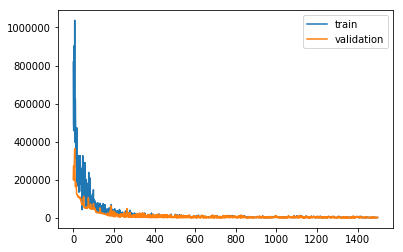

In [27]:
# fit network and save to history
history = model.fit(train_X, train_y, 
                    epochs=1500, 
                    batch_size=256, 
                    validation_data=(X_validation, Y_validation), 
                    verbose=2, 
                    shuffle=False)

# plot history
visualize.plot_loss(history)

# Visualize Results

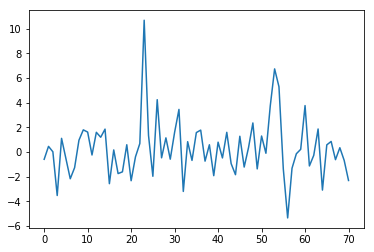

In [28]:
### KEEP THIS WORKING ####
yhat = predicts.predict_sequences_multiple(model, test_X, n_in, n_out)
visualize.plot_results_multiple(yhat, test_y[:,0], n_out, legend=False)
# visualize.plot_single(yhat, test_y, ticker, data_set_category='test')

# Single day predictions

In [ ]:
for i, x in enumerate(yhat):
    print(x, test_y[i,0])

In [ ]:
###### TODO METHOD####
#import predicts
## copy weights
#old_weights=model.get_weights()
#
#new_model = Sequential()
#new_model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2]),
#          return_sequences=True, activation='tanh'))
#new_model.add(Dropout(0.5))
#new_model.add(LSTM(10, activation='tanh'))
#new_model.add(Dropout(0.5))
#new_model.add(Dense(1))
#new_model.compile(loss='mae', optimizer='adam')
## fit network
#new_model.set_weights(old_weights)
#predicts.onlineForecast(new_model, test_X, test_y)
## # # ____ # # #

# *** Test Reshaping Method

In [ ]:
# test dimension modification
import pandas as pd
df=pd.read_csv('testDim.csv')
features_test=list(df.columns)
df.head()

In [ ]:
n_in=2
n_out=1
tgt_tst='Var4'
df=ps.series_to_supervised(df, 
                           n_in=n_in, 
                           n_out=n_out, 
                           features=features_test)
df.head()

In [ ]:
test_frame=ps.frame_targets(df, 
                          features=features_test, 
                          n_out=n_out,
                          target=tgt_tst)
test_frame.head()

In [ ]:
X = test_frame.values[:, :-n_out]

In [ ]:
[print(x) for x in X]

In [ ]:
d=ps.shape(X, n_in, features_test)

In [ ]:
d[1,-1,:]

* Seems like dim is (observations, n_in, features), which is correct

* tensor should be (t-2)a, (t-2)b, (t-1)a, (t-1)b, etc. where a and b are features to properly reshape, thus current reshaping is working as expected